In [ ]:
from wordcloud import WordCloud
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer

from keras.utils import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.3 MB/s eta 0:00:00


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Train Ai/Data trầm cảm tư tử/Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
data['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

In [ ]:
data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [ ]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

In [ ]:
train_data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [ ]:
plx.bar(train_data,x=train_data['class'].value_counts().index.values,
        y=train_data['class'].value_counts(),color=['Suicide','Not Suicide'])

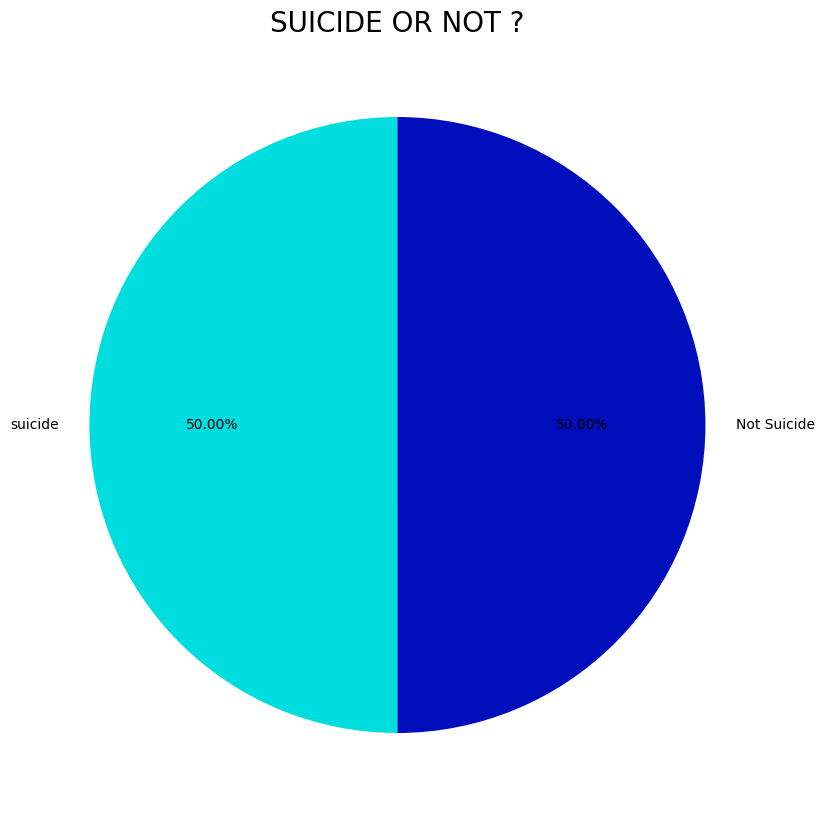

In [ ]:
plt.figure(figsize=(12,10))
plt.pie(train_data['class'].value_counts(),startangle=90,colors=['#00dddf','#000fbb'],
        autopct='%0.2f%%',labels=['suicide','Not Suicide'])
plt.title('SUICIDE OR NOT ?',fontdict={'size':20})
plt.show()

In [ ]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower() #Biến toàn bộ đoạn văn bản thành chữ thường
        sent=nfx.remove_special_characters(sent)#Gỡ bỏ các ký tự đặc biệt như dấu câu, ký tự không phải chữ cái hay số
        sent=nfx.remove_stopwords(sent)#Gỡ bỏ các từ không mang nghĩa như "and", "is",... Điều này giúp tập trung vào những từ quan trọng hơn trong văn bản
        # sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))#Đo chiều dài của đoạn văn bản sau khi xử lý
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [ ]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|██████████| 46415/46415 [00:01<00:00, 27987.24it/s]


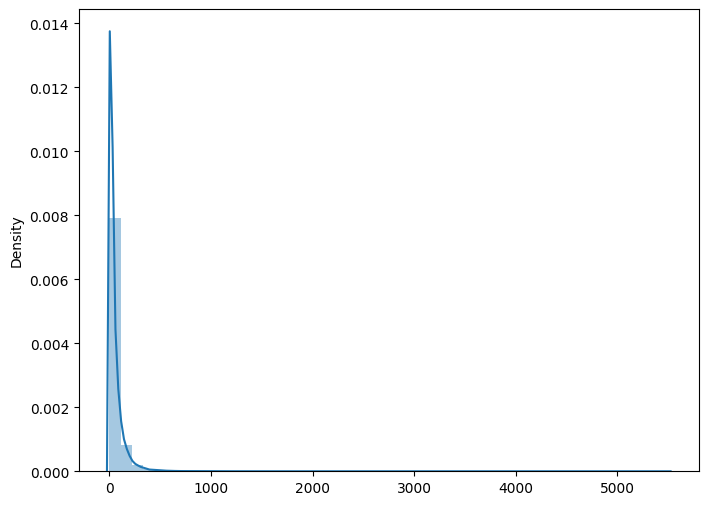

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(train_text_length)
plt.show()

In [ ]:
#chuyển text về số nguyên

#Phân tích từ vựng của tất cả các đoạn văn bản để tạo một bộ từ điển.
#Gắn số nguyên duy nhất cho mỗi từ trong từ điển.
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)
#Sau khi các đoạn văn bản đã qua xử lý được "học" bởi Tokenizer có
#thể sử dụng nó để chuyển đổi các đoạn văn bản thành các chuỗi số nguyên sử dụng phương thức texts_to_sequences.

In [ ]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

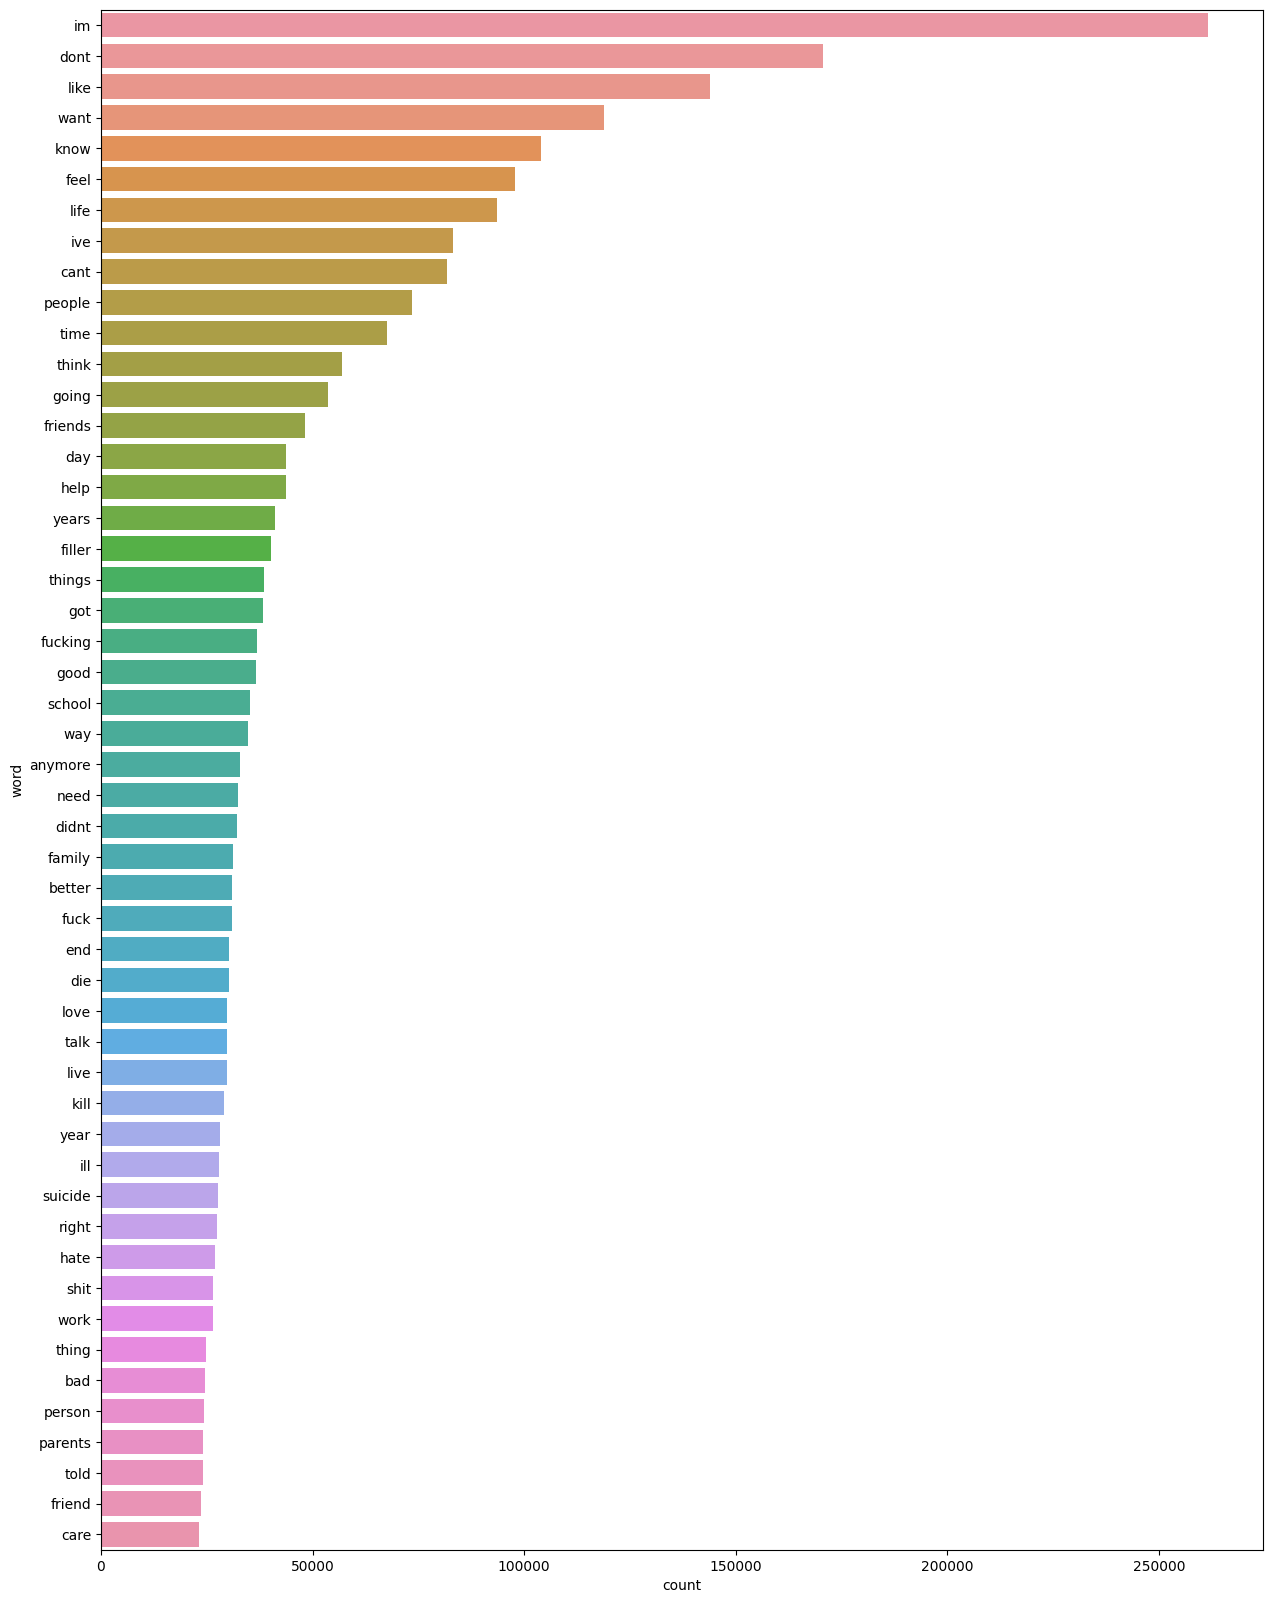

In [ ]:
plt.figure(figsize=(15,20))
sns.barplot(x='count',y='word',data=word_freq.iloc[:50])
plt.show()

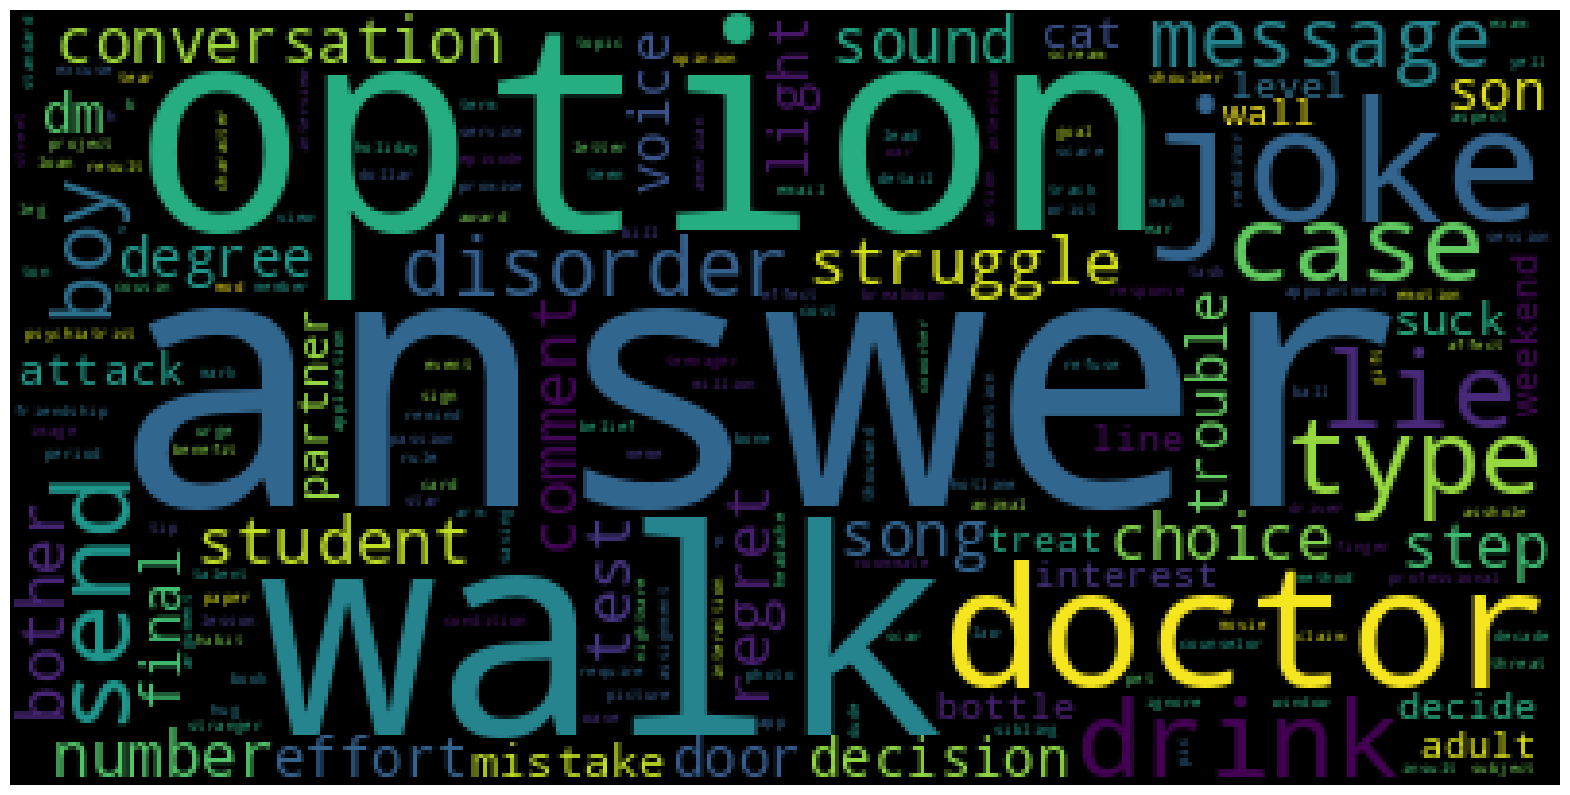

In [ ]:
feature_names=word_freq['word'].values
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">PREPROCESSING TEXT DATA</h1>

In [ ]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=40)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=40)

In [ ]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">GLOVE EMBEDDINGS</h1>


In [ ]:
# glove_embedding={}
with open('/content/drive/MyDrive/Train Ai/Data trầm cảm tư tử/glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [ ]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [ ]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">MODEL BUILDING</h1>

In [ ]:
model=Sequential()
model.add(Input(shape=(40,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=10,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/10
726/726 [==============================] - 58s 80ms/step - loss: 0.1996 - accuracy: 0.9232 - val_loss: 0.2049 - val_accuracy: 0.9222 - lr: 0.1000
Epoch 2/10
726/726 [==============================] - 64s 88ms/step - loss: 0.1940 - accuracy: 0.9256 - val_loss: 0.2311 - val_accuracy: 0.9106 - lr: 0.1000
Epoch 3/10
726/726 [==============================] - 57s 79ms/step - loss: 0.1901 - accuracy: 0.9264 - val_loss: 0.1897 - val_accuracy: 0.9268 - lr: 0.1000
Epoch 4/10
726/726 [==============================] - 58s 79ms/step - loss: 0.1870 - accuracy: 0.9292 - val_loss: 0.2110 - val_accuracy: 0.9192 - lr: 0.1000
Epoch 5/10
726/726 [==============================] - 62s 86ms/step - loss: 0.1845 - accuracy: 0.9296 - val_loss: 0.2284 - val_accuracy: 0.9138 - lr: 0.1000
Epoch 6/10
726/726 [==============================] - 58s 80ms/step - loss: 0.1822 - accuracy: 0.9298 - val_loss: 0.2487 - val_accuracy: 0.9010 - lr: 0.1000
Epoch 7/10
726/726 [==============================] - 60s 

In [ ]:
# Đường dẫn tới nơi bạn muốn lưu mô hình
model_save_path = "/content/drive/MyDrive/Train Ai/model/Suicidal_0.h5"

# Lưu mô hình
model.save(model_save_path)

In [ ]:
from keras.models import load_model

# Đường dẫn tới tệp mô hình đã lưu
model_filename = "/content/drive/MyDrive/Train Ai/model/Suicidal_0.h5"

# Tải mô hình
model  = load_model(model_filename)

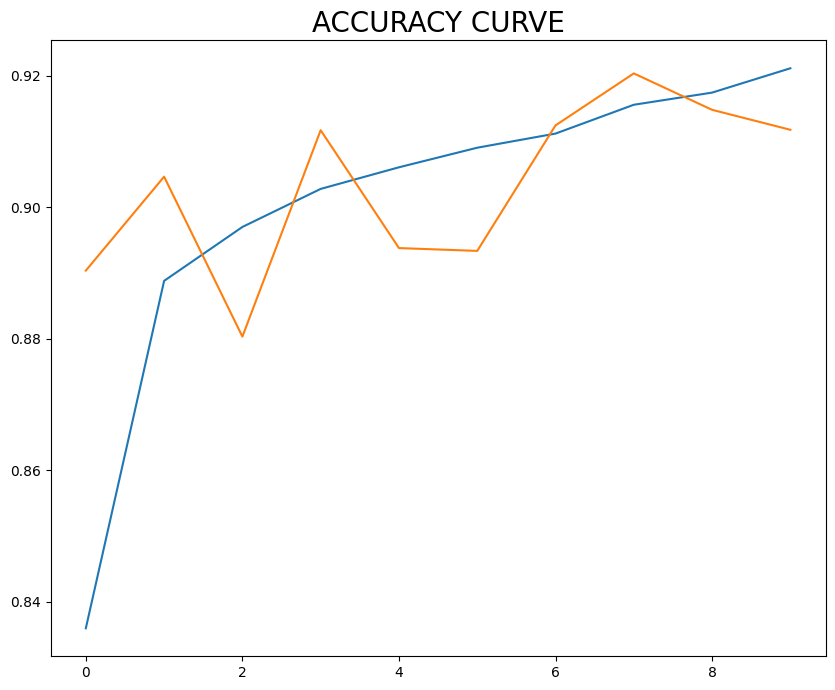

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

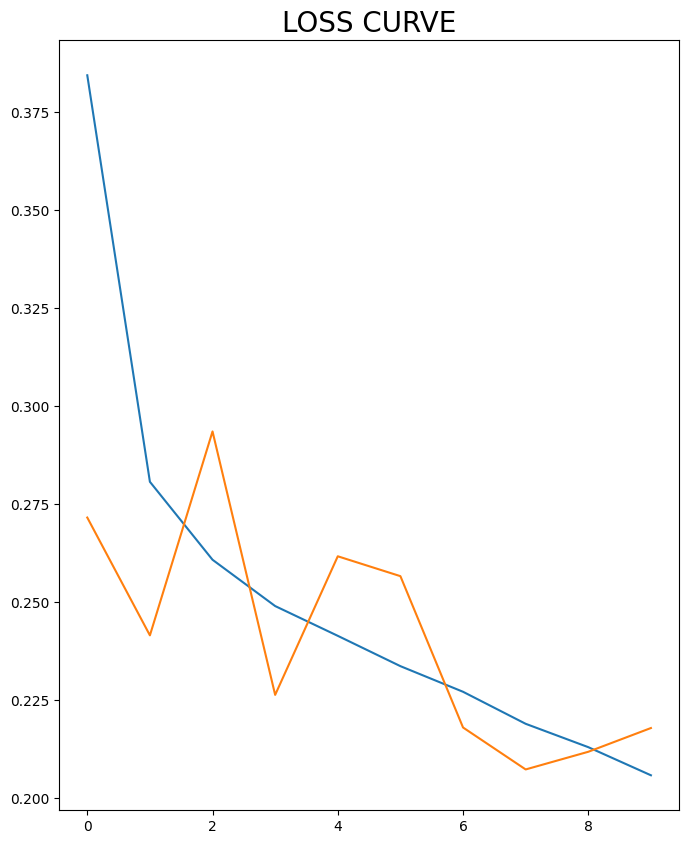

In [ ]:
plt.figure(figsize=(8,10))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Dự đoán dùng phương thức predict
test_predictions = model.predict(test_text_pad)
train_predictions = model.predict(train_text_pad)

# Chuyển đổi dự đoán thành các lớp
test_predicted_classes = (test_predictions > 0.7).astype(int)
train_predicted_classes = (train_predictions > 0.7).astype(int)

# In báo cáo phân loại
print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output, test_predicted_classes,
                            target_names=lbl_target.inverse_transform([0,1])))

print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output, train_predicted_classes,
                            target_names=lbl_target.inverse_transform([0,1])))


5802/5802 [==============================] - 51s 9ms/step
TESTING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.90      0.95      0.92     23209
     suicide       0.95      0.89      0.92     23206

    accuracy                           0.92     46415
   macro avg       0.92      0.92      0.92     46415
weighted avg       0.92      0.92      0.92     46415

TRAINING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.92      0.95      0.94     92828
     suicide       0.95      0.92      0.93     92831

    accuracy                           0.93    185659
   macro avg       0.93      0.93      0.93    185659
weighted avg       0.93      0.93      0.93    185659



In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer

from keras.models import load_model

# Đường dẫn tới tệp mô hình đã lưu
model_filename = "/content/drive/MyDrive/Train Ai/model/Suicidal_0.h5"

# Tải mô hình
model = load_model(model_filename)

# Tạo tokenizer sử dụng cho việc chuyển đổi văn bản thành dãy số
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)




In [ ]:
# Nhập đoạn văn bản từ bàn phím
input_text = input("Nhập đoạn văn bản: ")


# Chuyển đoạn văn bản thành dãy số sử dụng tokenizer

input_seq = tokenizer.texts_to_sequences([input_text])

# Padding đoạn văn bản để có cùng độ dài với dữ liệu huấn luyện
max_sequence_length = 40
input_seq_padded = pad_sequences(input_seq, maxlen=max_sequence_length, padding='post')

# Dự đoán sử dụng mô hình
prediction = model.predict(input_seq_padded)

# Ngưỡng để quyết định kết quả
threshold = 0.9

if prediction > threshold:
    print("Đoạn văn bản có khả năng trầm cảm.")
else:
    print("Đoạn văn bản không có khả năng trầm cảm.")

Nhập đoạn văn bản: toi muốn chết
1/1 [==============================] - 0s 381ms/step
Đoạn văn bản không có khả năng trầm cảm.
